In [1]:
import pandas as pd
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tools.eval_measures import rmse
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
pd.set_option('display.max_row', 100)
pd.set_option('display.max_column', 150)

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
Submission = pd.read_csv("sampleSubmission.csv")

In [3]:
train_x = train.drop("revenue",axis=1)
train_y = pd.DataFrame(train["revenue"])

In [4]:
print(train_x.shape)
print(test.shape)

(137, 42)
(100000, 42)


In [5]:
data = pd.concat([train_x,test])
print(data.shape)
print(data.isnull().sum().sum())

(100137, 42)
0


In [6]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [7]:
def feature_engineer(df):
    df = df.astype(float,errors="ignore")
    df["Open Date"] = pd.to_datetime(df["Open Date"], format='%m/%d/%Y')
    df = df.set_index("Open Date")
    df["Open_Year"] = df.index.year
    df["Open_Month"] = df.index.month
    df = df.reset_index(drop=True)
    df = create_dummies(df,"Type")
    df = create_dummies(df,"City Group")
    df = create_dummies(df,"City")
    df = create_dummies(df,"Open_Year")
    df = create_dummies(df,"Open_Month")
    df = df.drop(["City","City Group","Type","Open_Year","Open_Month"],axis=1)
    return df

In [8]:
data_rf = feature_engineer(data)

In [9]:
train_rf_x = data_rf[:137]
test_x = data_rf[137:]
print(train_rf_x.shape)
print(test_x.shape)

(137, 139)
(100000, 139)


In [10]:
train_rf_x = train_rf_x.drop("Id",axis=1)
Submission_id = pd.DataFrame(test_x["Id"]).astype(int).reset_index(drop=True)
test_rf_x = test_x.drop("Id",axis=1).reset_index(drop=True)

In [11]:
print(train_rf_x.shape) # Performed features normalization
print(train_y.shape)
print(test_rf_x.shape) # Performed features normalization
print(Submission_id.shape)

(137, 138)
(137, 1)
(100000, 138)
(100000, 1)


In [12]:
# Transform features only, and need no inverse_transform back
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
train_score_scaler = MinMaxScaler()
test_score_scaler = MinMaxScaler()
normalize_train = pd.DataFrame(train_score_scaler.fit_transform(train_rf_x.loc[:,"P1":"P37"]),columns = train_rf_x.loc[:,"P1":"P37"].columns)
normalize_test = pd.DataFrame(test_score_scaler.fit_transform(test_rf_x.loc[:,"P1":"P37"]),columns = test_rf_x.loc[:,"P1":"P37"].columns)
# z- score transformation for train_rf_x & test_rf_x
train_rf_x.loc[:,"P1":"P37"] = normalize_train
test_rf_x.loc[:,"P1":"P37"] = normalize_test
print(test_rf_x.isnull().sum().sum())
print(train_rf_x.loc[:,"P1":"P37"].equals(normalize_train))

0
True


In [13]:
# transformation for Train_y
train_y_scaler = StandardScaler()
normalize_train_y = pd.DataFrame(train_y_scaler.fit_transform(train_y),columns = train_y.columns)
log_transform_y = train_y.apply(np.log)
sqrt_log_y = train_y.apply(np.sqrt).apply(np.log)

# Feature Engineering Part: drop non-mutual features

In [14]:
drop_columns = (train_rf_x.sum()==0)
drop_columns = drop_columns[drop_columns].index

In [15]:
train_rf_x_drop = train_rf_x.drop(drop_columns,axis=1)
test_rf_x_drop = test_rf_x.drop(drop_columns,axis=1)
print(train_rf_x_drop.shape)
print(test_rf_x_drop.shape)

(137, 105)
(100000, 105)


In [16]:
drop_columns_months = train_rf_x_drop.iloc[:,-12:]
drop_columns_months = drop_columns_months.columns

In [17]:
train_rf_x_drop = train_rf_x_drop.drop(drop_columns_months,axis=1)
test_rf_x_drop = test_rf_x_drop.drop(drop_columns_months,axis=1)
print(train_rf_x_drop.shape)
print(test_rf_x_drop.shape)

(137, 93)
(100000, 93)


# Feature Engineering Part_2: Create N-way interaction features

In [18]:
from sklearn.preprocessing import PolynomialFeatures

In [19]:
# The interaction features can be as 2-way interaction, 3 way or more by adjusting the polynomial degree
n_way_interactions = PolynomialFeatures(2, interaction_only=True, include_bias=False)

In [20]:
n_way_interactions_columns = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11',
       'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21',
       'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31',
       'P32', 'P33', 'P34', 'P35', 'P36', 'P37']

In [21]:
train_interactions = pd.DataFrame(n_way_interactions.fit_transform(train_rf_x[n_way_interactions_columns]),columns = n_way_interactions.get_feature_names(train_rf_x[n_way_interactions_columns].columns))
test_interactions = pd.DataFrame(n_way_interactions.fit_transform(test_rf_x[n_way_interactions_columns]),columns = n_way_interactions.get_feature_names(test_rf_x[n_way_interactions_columns].columns))

In [22]:
train_rf_x_interaction = pd.concat([train_rf_x_drop,train_interactions],axis=1).drop(n_way_interactions_columns,axis=1)
test_rf_x_interaction = pd.concat([test_rf_x_drop,test_interactions],axis=1).drop(n_way_interactions_columns,axis=1)
print(train_rf_x_interaction.shape)
print(test_rf_x_interaction.shape)

(137, 722)
(100000, 722)


# XGboost, Grid Search with Features without interaction & sqrt & log_transformation_y FULL MODEL

In [23]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error
import pickle

In [24]:
hyperparameters_dict = {"learning_rate": [0.1,0.2,0.3],              # range: [0,1], default = 0.3
                   # Minimum loss reduction required to make a further partition on a leaf node of the tree. 
                   # The larger gamma is, the more conservative the algorithm will be.                   
                   "gamma": [i/10.0 for i in range(1,10,2)],
                   # Maximum depth of a tree. 
                   # Increasing this value will make the model more complex and more likely to overfit
                   "max_depth": [6], 
                   # Used to control over-fitting
                   # Too high values can lead to under-fitting hence, it should be tuned using grid search
                   "min_child_weight": [1],
                   # Usually this parameter is not needed, but it might help in logistic regression when class is extremely imbalanced
                   "max_delta_step": [0],
                   # Denotes the fraction of observations to be randomly samples for each tree
                   # Typical values: 0.5-1
                   "subsample": [0.8],
                   # Similar to max_features in GBM, Typical values: 0.5 - 1
                   # Denotes the fraction of columns to be randomly samples for each tree.
                   "colsample_bytree": [0.8,1],
                   "colsample_bylevel": [1], # colsample_bytree will control the decision over this, default = 1
                   "colsample_bynode": [1],  # colsample_bytree will control the decision over this, default = 1
                   # L2 regularization term on weights. Increasing this value will make model more conservative.
                   "reg_lambda": [1], # default = 1
                   # L1 regularization term on weights. Increasing this value will make model more conservative.
                   "reg_alpha": [1],  # default = 0
                   # Control the balance of positive and negative weights, useful for unbalanced classes. 
                   # A typical value to consider: sum(negative instances) / sum(positive instances)
                   "scale_pos_weight": [1],
                   # No. of trees ensemble, too high sometimes still can cause overfitting
                   "n_estimators": [300,400], 
                   "booster": ["gbtree"],
                   "verbosity": [1],
                   "objective": ["reg:squarederror"],
                   "seed": [50]
                   }

In [25]:
# To track the iteration records for parameters tuning
best_score_list = []
best_params_list = []
best_R2_list = []

In [110]:
hyperparameters_tuning = {'learning_rate': [0.1],               # 6th when boosting
                          'gamma': [0.1],                       # 3rd
                          'max_depth': [8],                     # 1st to tune
                          'min_child_weight': [5],              # 2nd
                          'max_delta_step': [0],
                          'subsample': [0.6],                   # 4th
                          'colsample_bytree': [0.2],            # 4th 
                          'colsample_bylevel': [1],
                          'colsample_bynode': [1],
                          'reg_lambda': [1],                    # 5th
                          'reg_alpha': [0],                     # 5th
                          'scale_pos_weight': [1.0],            # only when dealing with imbalance classes
                          'n_estimators': [180],                # 1st
                          "booster": ["gbtree"],
                          "verbosity": [1],
                          "objective": ["reg:squarederror"],
                          "seed": [1]
                         }                

In [111]:
# General Parameters setting inside Regressor
xgboost = xgb.XGBRegressor()

In [112]:
xgboost_grid = GridSearchCV(estimator = xgboost, param_grid = hyperparameters_tuning, cv = 10, iid = False, scoring="neg_mean_squared_error")

In [113]:
xgboost_grid.fit(train_rf_x_interaction,sqrt_log_y)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'learning_rate': [0.1], 'gamma': [0.1], 'max_depth': [8], 'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'max_delta_step': [0], 'subsample': [0.6], 'colsample_bytree': [0.2], 'colsample_bylevel': [1], 'colsample_bynode': [1], 'reg_lambda': [1], 'reg_alpha': [0], 'scale_pos_weight': [1.0], 'n_estimators': [180], 'booster': ['gbtree'], 'verbosity': [1], 'objective': ['reg:squarederror'], 'seed': [1]},
       pre_

In [114]:
best_cv_score = xgboost_grid.cv_results_ #thus no need train-test split, as cv will automatic run for us 
best_params = xgboost_grid.best_params_
best_score = xgboost_grid.best_score_
best_rf = xgboost_grid.best_estimator_
best_R2_score = best_rf.score(train_rf_x_interaction,sqrt_log_y)
best_score_list.append(best_score)
best_params_list.append(best_rf)
best_R2_list.append(best_R2_score)
print(best_score)
print(best_R2_score)
print(best_rf)

-0.04875500860226199
0.7587017852113982
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.2, gamma=0.1,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=5, missing=None, n_estimators=180,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1.0,
       seed=1, silent=None, subsample=0.6, verbosity=1)


In [115]:
print(best_score_list)
print(best_R2_list)
print(best_params_list)

[-0.055564186410920244, -0.05338464132446924, -0.053192503532846325, -0.05059398777834505, -0.04905679312688623, -0.04905679312688623, -0.05015480685951287, -0.04987940047713736, -0.04966166112309307, -0.04875500860226199]
[0.6929560862604007, 0.9617375680766168, 0.9747147400670209, 0.7547665724886303, 0.7116163093781017, 0.7116163093781017, 0.7975926188479993, 0.7975926188479993, 0.801892868278472, 0.7587017852113982]
[XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.2, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1.0,
       seed=1, silent=None, subsample=0.7, verbosity=1), XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.2, ga

# Create XGBoost's DMatrix, after fine tuning the parameters

In [116]:
trainDMat = xgb.DMatrix(data = train_rf_x_interaction, label = sqrt_log_y)

In [117]:
# Lower the learning_rate and set a large num_boost_round hyperparameter to ensure convergence. 
# If convergence is slow, retry with a slightly higher learning rate (e.g. 0.075 instead of 0.05)

In [120]:
num_boost_round = 15000
early_stopping_rounds = 50
# Activates early stopping. CV error needs to decrease at least every <early_stopping_rounds> round(s) to continue.
# Last entry in evaluation history is the one from best iteration.

In [123]:
hyperparameters_boosting ={'learning_rate': 0.001,               # 6th when boosting
                          'gamma': 0.1,                       # 3rd
                          'max_depth': 8,                     # 1st to tune
                          'min_child_weight': 5,              # 2nd
                          'max_delta_step': 0,
                          'subsample': 0.6,                   # 4th
                          'colsample_bytree': 0.2,            # 4th 
                          'colsample_bylevel': 1,
                          'colsample_bynode': 1,
                          'reg_lambda': 1,                    # 5th
                          'reg_alpha': 0,                     # 5th
                          'scale_pos_weight': 1.0,            # only when dealing with imbalance classes
                          'n_estimators': 180,                # 1st
                          "booster": "gbtree",
                          "verbosity": 1,
                          "objective": "reg:squarederror",
                          "seed": 1
                         }      

In [124]:
xgbCV = xgb.cv(
    params = hyperparameters_boosting, 
    dtrain = trainDMat, 
    num_boost_round = num_boost_round,
    nfold = 10, #same as CV
    metrics = {'rmse'},
    early_stopping_rounds = early_stopping_rounds,
    verbose_eval = True,     
)

[0]	train-rmse:7.09063+0.00710071	test-rmse:7.08965+0.0637428
[1]	train-rmse:7.08365+0.00710505	test-rmse:7.08267+0.0637379
[2]	train-rmse:7.07668+0.00709923	test-rmse:7.0757+0.0637439
[3]	train-rmse:7.06971+0.0070898	test-rmse:7.06873+0.0637541
[4]	train-rmse:7.06274+0.00709149	test-rmse:7.06176+0.0637526
[5]	train-rmse:7.05578+0.00708723	test-rmse:7.05479+0.0637565
[6]	train-rmse:7.04882+0.00708506	test-rmse:7.04784+0.0637592
[7]	train-rmse:7.04188+0.00708331	test-rmse:7.04089+0.0637613
[8]	train-rmse:7.03494+0.00707869	test-rmse:7.03396+0.0637665
[9]	train-rmse:7.02801+0.00706469	test-rmse:7.02703+0.0637807
[10]	train-rmse:7.0211+0.00705292	test-rmse:7.02012+0.0637937
[11]	train-rmse:7.01419+0.00704976	test-rmse:7.0132+0.0637966
[12]	train-rmse:7.00727+0.00704233	test-rmse:7.00629+0.063805
[13]	train-rmse:7.00037+0.00703193	test-rmse:6.99938+0.0638158
[14]	train-rmse:6.99346+0.00701909	test-rmse:6.99248+0.0638288
[15]	train-rmse:6.98656+0.0070181	test-rmse:6.98558+0.06383
[16]	train

[131]	train-rmse:6.23171+0.00615037	test-rmse:6.23069+0.064737
[132]	train-rmse:6.22557+0.00613911	test-rmse:6.22456+0.0647484
[133]	train-rmse:6.21944+0.00613922	test-rmse:6.21842+0.0647487
[134]	train-rmse:6.2133+0.00612874	test-rmse:6.21228+0.06476
[135]	train-rmse:6.20718+0.00612274	test-rmse:6.20616+0.0647663
[136]	train-rmse:6.20107+0.00611379	test-rmse:6.20005+0.0647753
[137]	train-rmse:6.19496+0.006097	test-rmse:6.19394+0.0647929
[138]	train-rmse:6.18886+0.00609369	test-rmse:6.18784+0.0647969
[139]	train-rmse:6.18276+0.00608665	test-rmse:6.18174+0.0648043
[140]	train-rmse:6.17667+0.00608557	test-rmse:6.17565+0.0648053
[141]	train-rmse:6.17059+0.00607134	test-rmse:6.16957+0.0648192
[142]	train-rmse:6.16451+0.00606361	test-rmse:6.16349+0.0648273
[143]	train-rmse:6.15844+0.00605784	test-rmse:6.15742+0.0648333
[144]	train-rmse:6.15237+0.00605346	test-rmse:6.15135+0.0648388
[145]	train-rmse:6.14632+0.00604937	test-rmse:6.1453+0.0648431
[146]	train-rmse:6.14028+0.00604769	test-rmse:6

[260]	train-rmse:5.48785+0.0053122	test-rmse:5.4868+0.0656235
[261]	train-rmse:5.48245+0.00531264	test-rmse:5.48139+0.0656244
[262]	train-rmse:5.47705+0.00531274	test-rmse:5.476+0.0656246
[263]	train-rmse:5.47166+0.00530029	test-rmse:5.4706+0.0656378
[264]	train-rmse:5.46627+0.0052917	test-rmse:5.46521+0.0656477
[265]	train-rmse:5.46088+0.00529035	test-rmse:5.45982+0.0656492
[266]	train-rmse:5.4555+0.00528404	test-rmse:5.45444+0.0656564
[267]	train-rmse:5.45014+0.00529076	test-rmse:5.44908+0.06565
[268]	train-rmse:5.44477+0.00528802	test-rmse:5.44371+0.0656532
[269]	train-rmse:5.4394+0.00528161	test-rmse:5.43834+0.0656607
[270]	train-rmse:5.43404+0.00528995	test-rmse:5.43298+0.0656539
[271]	train-rmse:5.4287+0.00529015	test-rmse:5.42764+0.065654
[272]	train-rmse:5.42336+0.00528106	test-rmse:5.4223+0.0656624
[273]	train-rmse:5.41803+0.00527454	test-rmse:5.41696+0.0656695
[274]	train-rmse:5.41269+0.00526067	test-rmse:5.41163+0.0656835
[275]	train-rmse:5.40736+0.00525588	test-rmse:5.4063+

[390]	train-rmse:4.82828+0.00474203	test-rmse:4.82718+0.0662444
[391]	train-rmse:4.82353+0.00473914	test-rmse:4.82242+0.066247
[392]	train-rmse:4.81878+0.00473886	test-rmse:4.81768+0.0662481
[393]	train-rmse:4.81403+0.00472184	test-rmse:4.81293+0.0662662
[394]	train-rmse:4.80928+0.0047148	test-rmse:4.80818+0.0662726
[395]	train-rmse:4.80455+0.00470319	test-rmse:4.80344+0.0662847
[396]	train-rmse:4.79981+0.00469425	test-rmse:4.79871+0.0662942
[397]	train-rmse:4.79509+0.00468719	test-rmse:4.79398+0.0663021
[398]	train-rmse:4.79036+0.004685	test-rmse:4.78925+0.0663048
[399]	train-rmse:4.78566+0.00466813	test-rmse:4.78455+0.0663212
[400]	train-rmse:4.78095+0.00466634	test-rmse:4.77984+0.0663232
[401]	train-rmse:4.77624+0.00466379	test-rmse:4.77513+0.0663246
[402]	train-rmse:4.77153+0.0046587	test-rmse:4.77042+0.0663302
[403]	train-rmse:4.76683+0.00465422	test-rmse:4.76572+0.066336
[404]	train-rmse:4.76215+0.00465213	test-rmse:4.76104+0.0663382
[405]	train-rmse:4.75746+0.00463719	test-rmse:

[520]	train-rmse:4.24834+0.00412112	test-rmse:4.24718+0.066917
[521]	train-rmse:4.24416+0.00411694	test-rmse:4.243+0.0669219
[522]	train-rmse:4.23999+0.00410759	test-rmse:4.23884+0.0669331
[523]	train-rmse:4.23583+0.00409738	test-rmse:4.23467+0.0669444
[524]	train-rmse:4.23167+0.00410079	test-rmse:4.23051+0.0669419
[525]	train-rmse:4.22751+0.00409442	test-rmse:4.22635+0.0669489
[526]	train-rmse:4.22335+0.00408287	test-rmse:4.22219+0.0669613
[527]	train-rmse:4.21919+0.00408285	test-rmse:4.21803+0.0669618
[528]	train-rmse:4.21505+0.00408277	test-rmse:4.21389+0.0669614
[529]	train-rmse:4.21091+0.00407492	test-rmse:4.20975+0.0669683
[530]	train-rmse:4.20677+0.00407152	test-rmse:4.20561+0.066973
[531]	train-rmse:4.20263+0.00407866	test-rmse:4.20146+0.0669667
[532]	train-rmse:4.1985+0.00407935	test-rmse:4.19734+0.0669657
[533]	train-rmse:4.19437+0.0040753	test-rmse:4.19321+0.0669699
[534]	train-rmse:4.19025+0.00408033	test-rmse:4.18909+0.0669663
[535]	train-rmse:4.18613+0.00407285	test-rmse:

[650]	train-rmse:3.73848+0.00362379	test-rmse:3.73726+0.0674847
[651]	train-rmse:3.73481+0.00362165	test-rmse:3.73359+0.0674877
[652]	train-rmse:3.73113+0.00361372	test-rmse:3.72992+0.0674955
[653]	train-rmse:3.72747+0.00361534	test-rmse:3.72625+0.0674949
[654]	train-rmse:3.72382+0.0036033	test-rmse:3.7226+0.067508
[655]	train-rmse:3.72016+0.00359724	test-rmse:3.71894+0.0675165
[656]	train-rmse:3.7165+0.0035909	test-rmse:3.71528+0.0675221
[657]	train-rmse:3.71285+0.00359699	test-rmse:3.71163+0.0675171
[658]	train-rmse:3.7092+0.00359273	test-rmse:3.70798+0.0675205
[659]	train-rmse:3.70555+0.00358827	test-rmse:3.70433+0.067525
[660]	train-rmse:3.70191+0.00358725	test-rmse:3.70068+0.0675262
[661]	train-rmse:3.69826+0.00359433	test-rmse:3.69704+0.0675201
[662]	train-rmse:3.69462+0.00358709	test-rmse:3.6934+0.0675279
[663]	train-rmse:3.691+0.00358798	test-rmse:3.68978+0.0675268
[664]	train-rmse:3.68737+0.00358429	test-rmse:3.68614+0.0675316
[665]	train-rmse:3.68374+0.0035775	test-rmse:3.682

[780]	train-rmse:3.29026+0.00318411	test-rmse:3.28898+0.0680027
[781]	train-rmse:3.28703+0.00318061	test-rmse:3.28574+0.0680062
[782]	train-rmse:3.28381+0.00317307	test-rmse:3.28252+0.0680141
[783]	train-rmse:3.28059+0.00317933	test-rmse:3.27931+0.0680098
[784]	train-rmse:3.27738+0.00318052	test-rmse:3.27609+0.0680111
[785]	train-rmse:3.27416+0.00317072	test-rmse:3.27287+0.06802
[786]	train-rmse:3.27094+0.00316582	test-rmse:3.26965+0.068026
[787]	train-rmse:3.26773+0.00316373	test-rmse:3.26644+0.0680298
[788]	train-rmse:3.26452+0.00316556	test-rmse:3.26323+0.0680273
[789]	train-rmse:3.26131+0.00316531	test-rmse:3.26002+0.0680269
[790]	train-rmse:3.25811+0.00316358	test-rmse:3.25682+0.0680284
[791]	train-rmse:3.25491+0.00316683	test-rmse:3.25362+0.0680252
[792]	train-rmse:3.25173+0.00316915	test-rmse:3.25043+0.0680262
[793]	train-rmse:3.24854+0.00316661	test-rmse:3.24724+0.0680285
[794]	train-rmse:3.24534+0.00315873	test-rmse:3.24405+0.068037
[795]	train-rmse:3.24216+0.0031576	test-rmse

[909]	train-rmse:2.89914+0.0028277	test-rmse:2.89778+0.0684483
[910]	train-rmse:2.89629+0.00282289	test-rmse:2.89493+0.0684545
[911]	train-rmse:2.89345+0.00281181	test-rmse:2.89208+0.0684655
[912]	train-rmse:2.89061+0.0028101	test-rmse:2.88925+0.0684682
[913]	train-rmse:2.88779+0.00281361	test-rmse:2.88643+0.0684634
[914]	train-rmse:2.88497+0.00281269	test-rmse:2.8836+0.068465
[915]	train-rmse:2.88214+0.00280857	test-rmse:2.88077+0.0684704
[916]	train-rmse:2.87931+0.00280001	test-rmse:2.87795+0.0684782
[917]	train-rmse:2.87649+0.00279642	test-rmse:2.87512+0.0684831
[918]	train-rmse:2.87367+0.00279622	test-rmse:2.87231+0.0684842
[919]	train-rmse:2.87086+0.00279913	test-rmse:2.86949+0.0684806
[920]	train-rmse:2.86804+0.0027987	test-rmse:2.86667+0.0684813
[921]	train-rmse:2.86522+0.00278938	test-rmse:2.86385+0.0684892
[922]	train-rmse:2.86241+0.00278766	test-rmse:2.86104+0.0684908
[923]	train-rmse:2.85961+0.00278813	test-rmse:2.85824+0.06849
[924]	train-rmse:2.8568+0.0027876	test-rmse:2.8

[1038]	train-rmse:2.55499+0.00252649	test-rmse:2.55354+0.0688376
[1039]	train-rmse:2.55249+0.00252363	test-rmse:2.55104+0.0688416
[1040]	train-rmse:2.55+0.00252412	test-rmse:2.54855+0.0688412
[1041]	train-rmse:2.5475+0.00252119	test-rmse:2.54605+0.0688448
[1042]	train-rmse:2.54501+0.00251742	test-rmse:2.54356+0.0688475
[1043]	train-rmse:2.54252+0.00251204	test-rmse:2.54107+0.0688556
[1044]	train-rmse:2.54004+0.00251765	test-rmse:2.53858+0.0688491
[1045]	train-rmse:2.53755+0.0025237	test-rmse:2.5361+0.0688432
[1046]	train-rmse:2.53507+0.00251629	test-rmse:2.53361+0.0688509
[1047]	train-rmse:2.53259+0.00252124	test-rmse:2.53113+0.0688458
[1048]	train-rmse:2.5301+0.00252471	test-rmse:2.52865+0.0688414
[1049]	train-rmse:2.52763+0.00252909	test-rmse:2.52618+0.0688389
[1050]	train-rmse:2.52516+0.00252582	test-rmse:2.5237+0.068842
[1051]	train-rmse:2.52269+0.00252963	test-rmse:2.52123+0.0688395
[1052]	train-rmse:2.52022+0.00252601	test-rmse:2.51876+0.0688412
[1053]	train-rmse:2.51776+0.002515

[1165]	train-rmse:2.25686+0.00228385	test-rmse:2.25532+0.0691502
[1166]	train-rmse:2.25466+0.00227968	test-rmse:2.25312+0.0691566
[1167]	train-rmse:2.25247+0.0022875	test-rmse:2.25092+0.0691482
[1168]	train-rmse:2.25027+0.002289	test-rmse:2.24872+0.0691472
[1169]	train-rmse:2.24809+0.00228933	test-rmse:2.24654+0.0691492
[1170]	train-rmse:2.24589+0.0022847	test-rmse:2.24434+0.0691541
[1171]	train-rmse:2.2437+0.00228117	test-rmse:2.24215+0.0691576
[1172]	train-rmse:2.2415+0.00228423	test-rmse:2.23995+0.0691557
[1173]	train-rmse:2.23932+0.00228458	test-rmse:2.23777+0.0691542
[1174]	train-rmse:2.23714+0.00228838	test-rmse:2.23559+0.069153
[1175]	train-rmse:2.23495+0.00230443	test-rmse:2.2334+0.0691367
[1176]	train-rmse:2.23277+0.00230464	test-rmse:2.23122+0.0691365
[1177]	train-rmse:2.23059+0.00231505	test-rmse:2.22904+0.0691278
[1178]	train-rmse:2.22842+0.0023134	test-rmse:2.22686+0.0691299
[1179]	train-rmse:2.22624+0.00231015	test-rmse:2.22468+0.0691327
[1180]	train-rmse:2.22408+0.002306

[1292]	train-rmse:1.99419+0.00222502	test-rmse:1.99253+0.0692856
[1293]	train-rmse:1.99224+0.00223226	test-rmse:1.99059+0.0692809
[1294]	train-rmse:1.99031+0.00222555	test-rmse:1.98865+0.0692863
[1295]	train-rmse:1.98837+0.00221585	test-rmse:1.98671+0.0692981
[1296]	train-rmse:1.98642+0.00222202	test-rmse:1.98477+0.0692932
[1297]	train-rmse:1.98448+0.00222057	test-rmse:1.98282+0.0692979
[1298]	train-rmse:1.98255+0.00221786	test-rmse:1.98089+0.0693016
[1299]	train-rmse:1.98062+0.00221208	test-rmse:1.97896+0.0693058
[1300]	train-rmse:1.97869+0.00221247	test-rmse:1.97703+0.0693075
[1301]	train-rmse:1.97677+0.00220971	test-rmse:1.9751+0.0693119
[1302]	train-rmse:1.97485+0.00220757	test-rmse:1.97318+0.0693171
[1303]	train-rmse:1.97293+0.00221787	test-rmse:1.97126+0.0693035
[1304]	train-rmse:1.97101+0.0022167	test-rmse:1.96934+0.0693032
[1305]	train-rmse:1.96909+0.00221953	test-rmse:1.96743+0.0692997
[1306]	train-rmse:1.96717+0.00222053	test-rmse:1.9655+0.0692992
[1307]	train-rmse:1.96526+0.

[1419]	train-rmse:1.76271+0.00215557	test-rmse:1.76093+0.0694604
[1420]	train-rmse:1.761+0.00216268	test-rmse:1.75922+0.0694598
[1421]	train-rmse:1.75929+0.00216899	test-rmse:1.75751+0.0694559
[1422]	train-rmse:1.75758+0.00216761	test-rmse:1.7558+0.0694589
[1423]	train-rmse:1.75588+0.00217307	test-rmse:1.7541+0.069452
[1424]	train-rmse:1.75418+0.00217386	test-rmse:1.75239+0.0694509
[1425]	train-rmse:1.75249+0.00217274	test-rmse:1.7507+0.0694538
[1426]	train-rmse:1.75079+0.00216959	test-rmse:1.749+0.0694561
[1427]	train-rmse:1.74909+0.00216546	test-rmse:1.7473+0.0694627
[1428]	train-rmse:1.7474+0.00216809	test-rmse:1.74561+0.0694583
[1429]	train-rmse:1.7457+0.00216653	test-rmse:1.74391+0.0694599
[1430]	train-rmse:1.74401+0.00216427	test-rmse:1.74221+0.0694621
[1431]	train-rmse:1.74232+0.00216102	test-rmse:1.74052+0.069466
[1432]	train-rmse:1.74064+0.00214894	test-rmse:1.73885+0.0694785
[1433]	train-rmse:1.73897+0.00215104	test-rmse:1.73717+0.0694752
[1434]	train-rmse:1.73728+0.00214255	

[1546]	train-rmse:1.55903+0.00190454	test-rmse:1.55711+0.0698347
[1547]	train-rmse:1.55753+0.00189708	test-rmse:1.55561+0.0698477
[1548]	train-rmse:1.55603+0.00189357	test-rmse:1.55411+0.0698522
[1549]	train-rmse:1.55453+0.00189545	test-rmse:1.55261+0.0698499
[1550]	train-rmse:1.55304+0.00189447	test-rmse:1.55111+0.0698546
[1551]	train-rmse:1.55153+0.00189727	test-rmse:1.54961+0.0698525
[1552]	train-rmse:1.55004+0.00189893	test-rmse:1.54811+0.0698543
[1553]	train-rmse:1.54854+0.00189584	test-rmse:1.54662+0.0698601
[1554]	train-rmse:1.54705+0.00188814	test-rmse:1.54512+0.0698655
[1555]	train-rmse:1.54555+0.0018839	test-rmse:1.54362+0.0698701
[1556]	train-rmse:1.54406+0.00189556	test-rmse:1.54213+0.0698619
[1557]	train-rmse:1.54258+0.00188944	test-rmse:1.54064+0.0698687
[1558]	train-rmse:1.54108+0.00189191	test-rmse:1.53915+0.0698663
[1559]	train-rmse:1.5396+0.00189222	test-rmse:1.53767+0.0698679
[1560]	train-rmse:1.53811+0.00189462	test-rmse:1.53618+0.0698694
[1561]	train-rmse:1.53663+0

[1673]	train-rmse:1.37989+0.00173394	test-rmse:1.37782+0.0701177
[1674]	train-rmse:1.37858+0.00173127	test-rmse:1.3765+0.070122
[1675]	train-rmse:1.37726+0.00172225	test-rmse:1.37518+0.0701291
[1676]	train-rmse:1.37594+0.00172659	test-rmse:1.37386+0.0701269
[1677]	train-rmse:1.37462+0.00173062	test-rmse:1.37254+0.0701233
[1678]	train-rmse:1.37331+0.00172855	test-rmse:1.37123+0.0701226
[1679]	train-rmse:1.372+0.00172611	test-rmse:1.36992+0.0701256
[1680]	train-rmse:1.37069+0.00173424	test-rmse:1.3686+0.0701189
[1681]	train-rmse:1.36937+0.00173276	test-rmse:1.36729+0.070121
[1682]	train-rmse:1.36806+0.00172905	test-rmse:1.36597+0.07013
[1683]	train-rmse:1.36674+0.00173373	test-rmse:1.36465+0.0701277
[1684]	train-rmse:1.36543+0.00173262	test-rmse:1.36334+0.0701247
[1685]	train-rmse:1.36413+0.00173824	test-rmse:1.36204+0.0701222
[1686]	train-rmse:1.36282+0.00174369	test-rmse:1.36073+0.0701191
[1687]	train-rmse:1.36152+0.00174118	test-rmse:1.35943+0.0701245
[1688]	train-rmse:1.36022+0.00174

[1801]	train-rmse:1.22138+0.00174034	test-rmse:1.21912+0.0702383
[1802]	train-rmse:1.22021+0.00174027	test-rmse:1.21795+0.0702422
[1803]	train-rmse:1.21906+0.00174045	test-rmse:1.2168+0.0702436
[1804]	train-rmse:1.2179+0.00173261	test-rmse:1.21564+0.0702533
[1805]	train-rmse:1.21674+0.0017297	test-rmse:1.21448+0.0702531
[1806]	train-rmse:1.21558+0.00173715	test-rmse:1.21332+0.0702482
[1807]	train-rmse:1.21443+0.00173658	test-rmse:1.21216+0.0702485
[1808]	train-rmse:1.21328+0.00172924	test-rmse:1.21101+0.070257
[1809]	train-rmse:1.21213+0.0017231	test-rmse:1.20986+0.0702589
[1810]	train-rmse:1.21098+0.0017194	test-rmse:1.20871+0.0702645
[1811]	train-rmse:1.20984+0.00171878	test-rmse:1.20756+0.0702609
[1812]	train-rmse:1.20869+0.00171703	test-rmse:1.20641+0.0702585
[1813]	train-rmse:1.20754+0.00171888	test-rmse:1.20527+0.0702604
[1814]	train-rmse:1.2064+0.00171991	test-rmse:1.20413+0.0702584
[1815]	train-rmse:1.20527+0.00171512	test-rmse:1.20299+0.0702667
[1816]	train-rmse:1.20412+0.0017

[1929]	train-rmse:1.08235+0.0016778	test-rmse:1.07989+0.0703292
[1930]	train-rmse:1.08133+0.0016697	test-rmse:1.07887+0.0703389
[1931]	train-rmse:1.08032+0.00167108	test-rmse:1.07786+0.0703415
[1932]	train-rmse:1.07931+0.00166531	test-rmse:1.07685+0.0703509
[1933]	train-rmse:1.07829+0.0016713	test-rmse:1.07582+0.0703485
[1934]	train-rmse:1.07729+0.00166795	test-rmse:1.07482+0.0703513
[1935]	train-rmse:1.07628+0.00166022	test-rmse:1.07381+0.0703604
[1936]	train-rmse:1.07526+0.00166322	test-rmse:1.07278+0.0703632
[1937]	train-rmse:1.07426+0.00166966	test-rmse:1.07179+0.0703621
[1938]	train-rmse:1.07325+0.0016649	test-rmse:1.07078+0.0703668
[1939]	train-rmse:1.07224+0.00166897	test-rmse:1.06977+0.0703667
[1940]	train-rmse:1.07123+0.00166755	test-rmse:1.06876+0.0703683
[1941]	train-rmse:1.07023+0.00166048	test-rmse:1.06775+0.0703736
[1942]	train-rmse:1.06922+0.0016505	test-rmse:1.06675+0.0703672
[1943]	train-rmse:1.06822+0.00164938	test-rmse:1.06576+0.0703376
[1944]	train-rmse:1.06723+0.00

[2055]	train-rmse:0.962266+0.00165034	test-rmse:0.959654+0.0701612
[2056]	train-rmse:0.961373+0.00165722	test-rmse:0.958762+0.070152
[2057]	train-rmse:0.960484+0.00166099	test-rmse:0.957867+0.0701498
[2058]	train-rmse:0.959586+0.00166132	test-rmse:0.95696+0.0701533
[2059]	train-rmse:0.958689+0.0016701	test-rmse:0.956066+0.0701538
[2060]	train-rmse:0.957795+0.00165861	test-rmse:0.95517+0.0701647
[2061]	train-rmse:0.956902+0.00165444	test-rmse:0.954283+0.0701646
[2062]	train-rmse:0.956012+0.00165707	test-rmse:0.953391+0.070155
[2063]	train-rmse:0.955124+0.00166285	test-rmse:0.952498+0.0701511
[2064]	train-rmse:0.954248+0.00166105	test-rmse:0.951623+0.0701558
[2065]	train-rmse:0.95337+0.00165765	test-rmse:0.95074+0.0701538
[2066]	train-rmse:0.952492+0.00165418	test-rmse:0.949868+0.0701439
[2067]	train-rmse:0.951615+0.00165079	test-rmse:0.948986+0.0701417
[2068]	train-rmse:0.950738+0.00165294	test-rmse:0.948101+0.0701369
[2069]	train-rmse:0.949866+0.00164589	test-rmse:0.947221+0.0701399
[2

[2179]	train-rmse:0.858492+0.00172415	test-rmse:0.855723+0.0698557
[2180]	train-rmse:0.857704+0.00172225	test-rmse:0.854933+0.0698585
[2181]	train-rmse:0.856917+0.00172504	test-rmse:0.854144+0.0698589
[2182]	train-rmse:0.856138+0.00173111	test-rmse:0.853357+0.0698504
[2183]	train-rmse:0.855357+0.00173063	test-rmse:0.852576+0.0698379
[2184]	train-rmse:0.854579+0.00173555	test-rmse:0.851788+0.069829
[2185]	train-rmse:0.853799+0.00174034	test-rmse:0.850998+0.0698282
[2186]	train-rmse:0.853015+0.00174265	test-rmse:0.850209+0.0698339
[2187]	train-rmse:0.852242+0.0017388	test-rmse:0.849437+0.0698303
[2188]	train-rmse:0.851478+0.00174042	test-rmse:0.848666+0.0698196
[2189]	train-rmse:0.8507+0.00172692	test-rmse:0.847896+0.0698147
[2190]	train-rmse:0.849932+0.00172962	test-rmse:0.847131+0.0698156
[2191]	train-rmse:0.849163+0.00172774	test-rmse:0.846356+0.0698202
[2192]	train-rmse:0.848395+0.00172781	test-rmse:0.845586+0.0698191
[2193]	train-rmse:0.847621+0.001724	test-rmse:0.844814+0.0698106
[

[2303]	train-rmse:0.767496+0.00186464	test-rmse:0.764725+0.0691273
[2304]	train-rmse:0.766813+0.00186558	test-rmse:0.764044+0.069131
[2305]	train-rmse:0.766129+0.00186661	test-rmse:0.763376+0.0691348
[2306]	train-rmse:0.765438+0.00187448	test-rmse:0.762684+0.0691302
[2307]	train-rmse:0.764759+0.00187336	test-rmse:0.762002+0.0691274
[2308]	train-rmse:0.764071+0.00186711	test-rmse:0.761308+0.0691264
[2309]	train-rmse:0.76339+0.00185645	test-rmse:0.760619+0.0691309
[2310]	train-rmse:0.762716+0.00186691	test-rmse:0.759944+0.0691184
[2311]	train-rmse:0.762044+0.0018756	test-rmse:0.759266+0.0691124
[2312]	train-rmse:0.761363+0.00187194	test-rmse:0.758573+0.0691128
[2313]	train-rmse:0.760686+0.00187801	test-rmse:0.757896+0.0690984
[2314]	train-rmse:0.760007+0.00187913	test-rmse:0.757225+0.0690825
[2315]	train-rmse:0.759329+0.00188743	test-rmse:0.756551+0.0690868
[2316]	train-rmse:0.758652+0.00189127	test-rmse:0.755869+0.0690908
[2317]	train-rmse:0.75798+0.00189903	test-rmse:0.755193+0.069088


[2427]	train-rmse:0.687594+0.00193978	test-rmse:0.684938+0.0685339
[2428]	train-rmse:0.686993+0.0019383	test-rmse:0.684331+0.0685218
[2429]	train-rmse:0.686396+0.00193286	test-rmse:0.683736+0.0685106
[2430]	train-rmse:0.685803+0.00193003	test-rmse:0.683141+0.0685109
[2431]	train-rmse:0.685204+0.00192968	test-rmse:0.68254+0.0684942
[2432]	train-rmse:0.684599+0.0019286	test-rmse:0.681931+0.0684854
[2433]	train-rmse:0.683995+0.00193526	test-rmse:0.681336+0.0684808
[2434]	train-rmse:0.683396+0.00192894	test-rmse:0.680728+0.0684791
[2435]	train-rmse:0.682796+0.00192527	test-rmse:0.680124+0.0684648
[2436]	train-rmse:0.682201+0.00193426	test-rmse:0.679513+0.0684533
[2437]	train-rmse:0.681603+0.00193146	test-rmse:0.678892+0.0684465
[2438]	train-rmse:0.681008+0.00193017	test-rmse:0.678292+0.068452
[2439]	train-rmse:0.680412+0.00192361	test-rmse:0.6777+0.068456
[2440]	train-rmse:0.679826+0.00193305	test-rmse:0.677124+0.0684381
[2441]	train-rmse:0.679222+0.00192119	test-rmse:0.676524+0.0684514
[2

[2551]	train-rmse:0.617595+0.00191422	test-rmse:0.615249+0.0678549
[2552]	train-rmse:0.61707+0.00191506	test-rmse:0.614723+0.0678447
[2553]	train-rmse:0.616535+0.00191937	test-rmse:0.614187+0.0678451
[2554]	train-rmse:0.616007+0.00191085	test-rmse:0.613651+0.0678615
[2555]	train-rmse:0.615478+0.00192132	test-rmse:0.613125+0.0678479
[2556]	train-rmse:0.614957+0.00192471	test-rmse:0.612606+0.067839
[2557]	train-rmse:0.614431+0.00192134	test-rmse:0.612087+0.0678164
[2558]	train-rmse:0.613905+0.00193123	test-rmse:0.611557+0.0678029
[2559]	train-rmse:0.613385+0.00191885	test-rmse:0.611032+0.0678026
[2560]	train-rmse:0.612857+0.00190982	test-rmse:0.610509+0.0678115
[2561]	train-rmse:0.612338+0.00191766	test-rmse:0.609978+0.0678159
[2562]	train-rmse:0.611827+0.00192242	test-rmse:0.609479+0.0678066
[2563]	train-rmse:0.611303+0.00192843	test-rmse:0.608951+0.0677984
[2564]	train-rmse:0.610791+0.00192514	test-rmse:0.608448+0.0678007
[2565]	train-rmse:0.610269+0.00192369	test-rmse:0.607916+0.06779

[2675]	train-rmse:0.556313+0.00195563	test-rmse:0.554535+0.0672759
[2676]	train-rmse:0.555852+0.00196777	test-rmse:0.554082+0.0672445
[2677]	train-rmse:0.555394+0.00196575	test-rmse:0.553641+0.0672484
[2678]	train-rmse:0.554928+0.00196827	test-rmse:0.553175+0.0672435
[2679]	train-rmse:0.554473+0.00196996	test-rmse:0.552717+0.0672377
[2680]	train-rmse:0.554017+0.00197747	test-rmse:0.552264+0.0672276
[2681]	train-rmse:0.553561+0.00198004	test-rmse:0.551836+0.067215
[2682]	train-rmse:0.553098+0.00198215	test-rmse:0.551371+0.0672316
[2683]	train-rmse:0.552642+0.0019884	test-rmse:0.550926+0.0672039
[2684]	train-rmse:0.552185+0.00199382	test-rmse:0.550459+0.067204
[2685]	train-rmse:0.55172+0.00198709	test-rmse:0.549992+0.0672011
[2686]	train-rmse:0.551275+0.00198846	test-rmse:0.549564+0.0671826
[2687]	train-rmse:0.550818+0.00199061	test-rmse:0.549104+0.0671823
[2688]	train-rmse:0.550366+0.0020047	test-rmse:0.548657+0.0671669
[2689]	train-rmse:0.549918+0.00201069	test-rmse:0.548217+0.0671634


[2799]	train-rmse:0.502742+0.0019752	test-rmse:0.502023+0.0665226
[2800]	train-rmse:0.502347+0.00197196	test-rmse:0.501639+0.0665187
[2801]	train-rmse:0.501944+0.00197248	test-rmse:0.501242+0.0665191
[2802]	train-rmse:0.501537+0.0019714	test-rmse:0.50084+0.066539
[2803]	train-rmse:0.501125+0.00197009	test-rmse:0.500435+0.0665273
[2804]	train-rmse:0.500727+0.00196619	test-rmse:0.50005+0.0665252
[2805]	train-rmse:0.500327+0.0019728	test-rmse:0.499668+0.0664997
[2806]	train-rmse:0.499921+0.0019679	test-rmse:0.499266+0.0665038
[2807]	train-rmse:0.499521+0.00197651	test-rmse:0.498869+0.0664752
[2808]	train-rmse:0.499118+0.00197341	test-rmse:0.498475+0.0664537
[2809]	train-rmse:0.498722+0.00197724	test-rmse:0.498089+0.0664377
[2810]	train-rmse:0.49832+0.00197209	test-rmse:0.497701+0.0664398
[2811]	train-rmse:0.497918+0.00197102	test-rmse:0.497319+0.0664551
[2812]	train-rmse:0.497531+0.00197258	test-rmse:0.49694+0.0664513
[2813]	train-rmse:0.497132+0.00197251	test-rmse:0.496558+0.0664333
[281

[2923]	train-rmse:0.455862+0.0020285	test-rmse:0.456513+0.0660172
[2924]	train-rmse:0.455515+0.00202837	test-rmse:0.456196+0.0660091
[2925]	train-rmse:0.455167+0.00202827	test-rmse:0.45586+0.0659984
[2926]	train-rmse:0.454817+0.00202603	test-rmse:0.455515+0.0660183
[2927]	train-rmse:0.454468+0.00203112	test-rmse:0.455183+0.0659997
[2928]	train-rmse:0.454109+0.00202696	test-rmse:0.454829+0.0659915
[2929]	train-rmse:0.453763+0.00202369	test-rmse:0.454491+0.0659961
[2930]	train-rmse:0.453421+0.00203015	test-rmse:0.454165+0.0659806
[2931]	train-rmse:0.453086+0.00202937	test-rmse:0.453856+0.065964
[2932]	train-rmse:0.452742+0.00203624	test-rmse:0.453506+0.0659651
[2933]	train-rmse:0.452384+0.00203328	test-rmse:0.453163+0.0659506
[2934]	train-rmse:0.452031+0.00203175	test-rmse:0.452821+0.0659459
[2935]	train-rmse:0.451694+0.0020322	test-rmse:0.452488+0.0659493
[2936]	train-rmse:0.451345+0.00203327	test-rmse:0.452146+0.0659562
[2937]	train-rmse:0.450998+0.00202925	test-rmse:0.451811+0.0659591

[3047]	train-rmse:0.414998+0.00210069	test-rmse:0.417558+0.0652152
[3048]	train-rmse:0.414689+0.0021096	test-rmse:0.417259+0.0652034
[3049]	train-rmse:0.414379+0.00211592	test-rmse:0.416982+0.0652126
[3050]	train-rmse:0.414073+0.00211686	test-rmse:0.416706+0.0651826
[3051]	train-rmse:0.413771+0.00211063	test-rmse:0.416419+0.0651705
[3052]	train-rmse:0.413457+0.00211255	test-rmse:0.416142+0.0651571
[3053]	train-rmse:0.413153+0.0021158	test-rmse:0.415841+0.0651287
[3054]	train-rmse:0.412853+0.00211729	test-rmse:0.415556+0.0651352
[3055]	train-rmse:0.412546+0.00210889	test-rmse:0.415259+0.0651418
[3056]	train-rmse:0.412238+0.00211021	test-rmse:0.414953+0.0651468
[3057]	train-rmse:0.411933+0.00211154	test-rmse:0.414666+0.0651356
[3058]	train-rmse:0.411629+0.00212119	test-rmse:0.414388+0.0651002
[3059]	train-rmse:0.411321+0.00212495	test-rmse:0.414097+0.0650836
[3060]	train-rmse:0.41102+0.00212886	test-rmse:0.413802+0.0650743
[3061]	train-rmse:0.410722+0.0021263	test-rmse:0.413528+0.065085


[3171]	train-rmse:0.37915+0.00223105	test-rmse:0.384119+0.0643264
[3172]	train-rmse:0.378872+0.00223128	test-rmse:0.383869+0.0643254
[3173]	train-rmse:0.378611+0.00223926	test-rmse:0.38364+0.0643086
[3174]	train-rmse:0.37835+0.00224334	test-rmse:0.383411+0.0643086
[3175]	train-rmse:0.378087+0.0022464	test-rmse:0.383171+0.0643151
[3176]	train-rmse:0.377816+0.00223296	test-rmse:0.382925+0.0643104
[3177]	train-rmse:0.377544+0.0022358	test-rmse:0.382657+0.064304
[3178]	train-rmse:0.377273+0.00222939	test-rmse:0.382399+0.0643004
[3179]	train-rmse:0.377009+0.00223667	test-rmse:0.382161+0.0642764
[3180]	train-rmse:0.376737+0.00223416	test-rmse:0.381905+0.0642744
[3181]	train-rmse:0.376471+0.00224297	test-rmse:0.381669+0.0642582
[3182]	train-rmse:0.376205+0.00224789	test-rmse:0.381417+0.0642534
[3183]	train-rmse:0.375943+0.00225422	test-rmse:0.381176+0.0642547
[3184]	train-rmse:0.375675+0.00225334	test-rmse:0.380927+0.0642633
[3185]	train-rmse:0.375404+0.00225429	test-rmse:0.380679+0.0642666
[

[3295]	train-rmse:0.347763+0.00237508	test-rmse:0.355496+0.0634365
[3296]	train-rmse:0.347526+0.00236979	test-rmse:0.355298+0.0634117
[3297]	train-rmse:0.347299+0.00237338	test-rmse:0.355089+0.0633915
[3298]	train-rmse:0.347059+0.00237465	test-rmse:0.354869+0.0633879
[3299]	train-rmse:0.346819+0.00237965	test-rmse:0.354667+0.0633776
[3300]	train-rmse:0.346575+0.00237805	test-rmse:0.354449+0.0633676
[3301]	train-rmse:0.346336+0.00237275	test-rmse:0.354234+0.0633814
[3302]	train-rmse:0.346097+0.00237019	test-rmse:0.354024+0.0633693
[3303]	train-rmse:0.345864+0.00237787	test-rmse:0.353831+0.0633747
[3304]	train-rmse:0.345626+0.00236982	test-rmse:0.353625+0.0633781
[3305]	train-rmse:0.345389+0.00237584	test-rmse:0.353409+0.0633634
[3306]	train-rmse:0.345155+0.00237753	test-rmse:0.3532+0.0633651
[3307]	train-rmse:0.344921+0.00237462	test-rmse:0.352992+0.0633542
[3308]	train-rmse:0.344687+0.00237789	test-rmse:0.352783+0.0633441
[3309]	train-rmse:0.344449+0.00238469	test-rmse:0.352569+0.06332

[3419]	train-rmse:0.320205+0.00241023	test-rmse:0.331039+0.0626184
[3420]	train-rmse:0.319996+0.00240952	test-rmse:0.33086+0.0626022
[3421]	train-rmse:0.319787+0.00240969	test-rmse:0.330672+0.0626042
[3422]	train-rmse:0.31958+0.00241419	test-rmse:0.330491+0.0626007
[3423]	train-rmse:0.319365+0.00240681	test-rmse:0.330307+0.0625915
[3424]	train-rmse:0.319165+0.00240272	test-rmse:0.330146+0.0625734
[3425]	train-rmse:0.318966+0.00240421	test-rmse:0.329985+0.0625752
[3426]	train-rmse:0.318757+0.00240487	test-rmse:0.329794+0.0625734
[3427]	train-rmse:0.318545+0.00239768	test-rmse:0.329607+0.0625648
[3428]	train-rmse:0.318338+0.00239816	test-rmse:0.329427+0.0625558
[3429]	train-rmse:0.318144+0.00239743	test-rmse:0.329263+0.0625525
[3430]	train-rmse:0.317939+0.00239462	test-rmse:0.3291+0.0625493
[3431]	train-rmse:0.317742+0.00239662	test-rmse:0.328924+0.0625523
[3432]	train-rmse:0.317534+0.00239557	test-rmse:0.328748+0.0625296
[3433]	train-rmse:0.317328+0.00240241	test-rmse:0.328563+0.0625023

[3543]	train-rmse:0.296118+0.00243382	test-rmse:0.310434+0.0617095
[3544]	train-rmse:0.295933+0.0024335	test-rmse:0.310271+0.0617043
[3545]	train-rmse:0.295743+0.00243595	test-rmse:0.310106+0.0617079
[3546]	train-rmse:0.29556+0.00243824	test-rmse:0.309949+0.0617033
[3547]	train-rmse:0.295376+0.00244497	test-rmse:0.3098+0.0616994
[3548]	train-rmse:0.2952+0.00245351	test-rmse:0.309663+0.0616713
[3549]	train-rmse:0.295021+0.0024573	test-rmse:0.30951+0.0616418
[3550]	train-rmse:0.294837+0.00245405	test-rmse:0.309356+0.0616334
[3551]	train-rmse:0.294658+0.00245568	test-rmse:0.309198+0.0616333
[3552]	train-rmse:0.294473+0.00246383	test-rmse:0.309051+0.061609
[3553]	train-rmse:0.294293+0.00245868	test-rmse:0.308903+0.0616042
[3554]	train-rmse:0.294113+0.00245967	test-rmse:0.308751+0.0616112
[3555]	train-rmse:0.293931+0.00246346	test-rmse:0.308603+0.0616037
[3556]	train-rmse:0.293758+0.00246051	test-rmse:0.308449+0.0616153
[3557]	train-rmse:0.293579+0.0024604	test-rmse:0.308294+0.0616037
[3558

[3667]	train-rmse:0.275032+0.00255255	test-rmse:0.292942+0.0609399
[3668]	train-rmse:0.274877+0.00255567	test-rmse:0.292803+0.0609442
[3669]	train-rmse:0.274722+0.00255404	test-rmse:0.292687+0.0609298
[3670]	train-rmse:0.274562+0.0025581	test-rmse:0.292555+0.0609089
[3671]	train-rmse:0.274408+0.00255731	test-rmse:0.292432+0.0609048
[3672]	train-rmse:0.274246+0.00256531	test-rmse:0.292316+0.0609027
[3673]	train-rmse:0.274087+0.00256946	test-rmse:0.29218+0.0608851
[3674]	train-rmse:0.273925+0.00256535	test-rmse:0.292039+0.060899
[3675]	train-rmse:0.273768+0.00256958	test-rmse:0.291898+0.0609039
[3676]	train-rmse:0.273605+0.00256837	test-rmse:0.291751+0.0608934
[3677]	train-rmse:0.273453+0.00257479	test-rmse:0.291626+0.0608854
[3678]	train-rmse:0.273297+0.00257021	test-rmse:0.291492+0.0608882
[3679]	train-rmse:0.273141+0.00257912	test-rmse:0.291364+0.0608839
[3680]	train-rmse:0.272982+0.00258495	test-rmse:0.291236+0.0608642
[3681]	train-rmse:0.272819+0.00257811	test-rmse:0.291107+0.060877

[3791]	train-rmse:0.25658+0.00267565	test-rmse:0.278137+0.0603007
[3792]	train-rmse:0.256442+0.00267303	test-rmse:0.278032+0.0603018
[3793]	train-rmse:0.256308+0.00266546	test-rmse:0.277926+0.0603033
[3794]	train-rmse:0.256172+0.00266519	test-rmse:0.277829+0.0603147
[3795]	train-rmse:0.256035+0.00265906	test-rmse:0.277736+0.0603158
[3796]	train-rmse:0.255898+0.00265789	test-rmse:0.277641+0.0603137
[3797]	train-rmse:0.255762+0.00266216	test-rmse:0.277528+0.0602971
[3798]	train-rmse:0.25563+0.00266565	test-rmse:0.277429+0.0602997
[3799]	train-rmse:0.255494+0.00266703	test-rmse:0.277316+0.0602989
[3800]	train-rmse:0.255356+0.00267634	test-rmse:0.277194+0.0602857
[3801]	train-rmse:0.255217+0.00267353	test-rmse:0.277079+0.0602999
[3802]	train-rmse:0.25508+0.00267479	test-rmse:0.276982+0.0603044
[3803]	train-rmse:0.254939+0.00267471	test-rmse:0.276875+0.0602917
[3804]	train-rmse:0.254802+0.00268265	test-rmse:0.276773+0.0602715
[3805]	train-rmse:0.254662+0.00269337	test-rmse:0.276678+0.060244

[3914]	train-rmse:0.240742+0.00274387	test-rmse:0.266154+0.0595808
[3915]	train-rmse:0.24062+0.00274439	test-rmse:0.266058+0.0595741
[3916]	train-rmse:0.2405+0.00274617	test-rmse:0.26596+0.0595761
[3917]	train-rmse:0.24038+0.00274232	test-rmse:0.265877+0.0595679
[3918]	train-rmse:0.240251+0.00274809	test-rmse:0.265791+0.059557
[3919]	train-rmse:0.240133+0.00276012	test-rmse:0.265703+0.0595421
[3920]	train-rmse:0.240017+0.00276137	test-rmse:0.265633+0.0595315
[3921]	train-rmse:0.239893+0.002772	test-rmse:0.265548+0.0595199
[3922]	train-rmse:0.239771+0.0027683	test-rmse:0.26546+0.0595094
[3923]	train-rmse:0.239648+0.00276527	test-rmse:0.265359+0.0595068
[3924]	train-rmse:0.239526+0.00277075	test-rmse:0.265258+0.0594983
[3925]	train-rmse:0.2394+0.0027719	test-rmse:0.265166+0.0594888
[3926]	train-rmse:0.239283+0.00276793	test-rmse:0.265079+0.0594938
[3927]	train-rmse:0.239166+0.00276221	test-rmse:0.264982+0.0594973
[3928]	train-rmse:0.239055+0.00276378	test-rmse:0.264911+0.0594821
[3929]	t

[4038]	train-rmse:0.226711+0.00282011	test-rmse:0.256097+0.0590368
[4039]	train-rmse:0.226603+0.00282189	test-rmse:0.255998+0.0590293
[4040]	train-rmse:0.226499+0.00283286	test-rmse:0.255931+0.0590222
[4041]	train-rmse:0.22639+0.0028347	test-rmse:0.255856+0.0590171
[4042]	train-rmse:0.226278+0.00283773	test-rmse:0.255776+0.0590096
[4043]	train-rmse:0.226172+0.00284199	test-rmse:0.255699+0.059008
[4044]	train-rmse:0.226066+0.00283907	test-rmse:0.25562+0.0590091
[4045]	train-rmse:0.225963+0.00284056	test-rmse:0.255542+0.0590112
[4046]	train-rmse:0.22586+0.00284547	test-rmse:0.255477+0.0590104
[4047]	train-rmse:0.225758+0.00284622	test-rmse:0.255397+0.0590192
[4048]	train-rmse:0.225657+0.00285194	test-rmse:0.25533+0.0590043
[4049]	train-rmse:0.22555+0.00285573	test-rmse:0.25526+0.0589852
[4050]	train-rmse:0.225441+0.00285548	test-rmse:0.255184+0.0589885
[4051]	train-rmse:0.225339+0.00285676	test-rmse:0.255097+0.0589838
[4052]	train-rmse:0.225238+0.00285813	test-rmse:0.255023+0.0589831
[40

[4162]	train-rmse:0.214486+0.0028854	test-rmse:0.247787+0.0585077
[4163]	train-rmse:0.214394+0.0028822	test-rmse:0.247731+0.0585173
[4164]	train-rmse:0.214301+0.00287647	test-rmse:0.24766+0.058526
[4165]	train-rmse:0.214204+0.00288261	test-rmse:0.247595+0.0585223
[4166]	train-rmse:0.214106+0.00288144	test-rmse:0.247538+0.0585113
[4167]	train-rmse:0.214012+0.00288065	test-rmse:0.247491+0.0585013
[4168]	train-rmse:0.213921+0.00287653	test-rmse:0.247429+0.0585159
[4169]	train-rmse:0.213825+0.00287715	test-rmse:0.247375+0.0585275
[4170]	train-rmse:0.213733+0.00287662	test-rmse:0.247311+0.0585257
[4171]	train-rmse:0.213642+0.00287935	test-rmse:0.247262+0.0585258
[4172]	train-rmse:0.213548+0.00287841	test-rmse:0.247205+0.058519
[4173]	train-rmse:0.213453+0.00287871	test-rmse:0.247144+0.0585109
[4174]	train-rmse:0.213364+0.00288654	test-rmse:0.247081+0.0585016
[4175]	train-rmse:0.213278+0.00288775	test-rmse:0.247024+0.0584958
[4176]	train-rmse:0.213188+0.00288567	test-rmse:0.246963+0.0585005


[4285]	train-rmse:0.20399+0.00294846	test-rmse:0.24122+0.0581339
[4286]	train-rmse:0.203906+0.00294915	test-rmse:0.241174+0.0581273
[4287]	train-rmse:0.203821+0.00295291	test-rmse:0.241124+0.058127
[4288]	train-rmse:0.203747+0.00295284	test-rmse:0.241079+0.0581071
[4289]	train-rmse:0.203671+0.00295173	test-rmse:0.241029+0.0581209
[4290]	train-rmse:0.203589+0.00295477	test-rmse:0.240968+0.0581163
[4291]	train-rmse:0.203513+0.00295769	test-rmse:0.240923+0.0581139
[4292]	train-rmse:0.203434+0.00295911	test-rmse:0.240862+0.0581132
[4293]	train-rmse:0.203355+0.00295798	test-rmse:0.240821+0.0580974
[4294]	train-rmse:0.20327+0.00296069	test-rmse:0.240778+0.0580908
[4295]	train-rmse:0.203195+0.00295993	test-rmse:0.24074+0.0580933
[4296]	train-rmse:0.203114+0.00295866	test-rmse:0.240691+0.0581017
[4297]	train-rmse:0.203037+0.00295062	test-rmse:0.240646+0.0581008
[4298]	train-rmse:0.202963+0.00295436	test-rmse:0.240597+0.0580912
[4299]	train-rmse:0.202882+0.00296328	test-rmse:0.240535+0.0580963


[4408]	train-rmse:0.194911+0.00298606	test-rmse:0.235752+0.0579087
[4409]	train-rmse:0.194845+0.00298937	test-rmse:0.235719+0.0579125
[4410]	train-rmse:0.194779+0.00299365	test-rmse:0.235686+0.0579055
[4411]	train-rmse:0.19471+0.00299158	test-rmse:0.23565+0.0579087
[4412]	train-rmse:0.194643+0.00298821	test-rmse:0.235611+0.0579091
[4413]	train-rmse:0.194575+0.00299077	test-rmse:0.235571+0.0578994
[4414]	train-rmse:0.194509+0.00299513	test-rmse:0.235538+0.0579079
[4415]	train-rmse:0.194441+0.00300217	test-rmse:0.235503+0.0579144
[4416]	train-rmse:0.194376+0.00300091	test-rmse:0.235469+0.0579089
[4417]	train-rmse:0.19432+0.00300576	test-rmse:0.235434+0.0579062
[4418]	train-rmse:0.194251+0.00300839	test-rmse:0.235394+0.0579174
[4419]	train-rmse:0.194188+0.00301038	test-rmse:0.235359+0.0579051
[4420]	train-rmse:0.194119+0.00300758	test-rmse:0.23532+0.0578922
[4421]	train-rmse:0.194056+0.00300496	test-rmse:0.235273+0.0578956
[4422]	train-rmse:0.193986+0.00300614	test-rmse:0.235238+0.0578963

[4532]	train-rmse:0.186929+0.00309123	test-rmse:0.231181+0.0576865
[4533]	train-rmse:0.186872+0.00308853	test-rmse:0.231145+0.0576811
[4534]	train-rmse:0.186812+0.00308727	test-rmse:0.231112+0.0576882
[4535]	train-rmse:0.186752+0.00308769	test-rmse:0.231079+0.0576907
[4536]	train-rmse:0.186696+0.00308718	test-rmse:0.231047+0.0576728
[4537]	train-rmse:0.186642+0.00309134	test-rmse:0.231019+0.0576749
[4538]	train-rmse:0.186582+0.00309085	test-rmse:0.230988+0.0576693
[4539]	train-rmse:0.186524+0.00309108	test-rmse:0.230951+0.057664
[4540]	train-rmse:0.186474+0.00309169	test-rmse:0.230919+0.0576554
[4541]	train-rmse:0.186416+0.0030912	test-rmse:0.230887+0.0576519
[4542]	train-rmse:0.186357+0.00308354	test-rmse:0.230852+0.0576562
[4543]	train-rmse:0.186295+0.00308028	test-rmse:0.230817+0.057654
[4544]	train-rmse:0.186236+0.00308841	test-rmse:0.230788+0.0576528
[4545]	train-rmse:0.186174+0.00308429	test-rmse:0.230761+0.0576558
[4546]	train-rmse:0.186119+0.00309012	test-rmse:0.230739+0.057645

[4655]	train-rmse:0.18008+0.00316093	test-rmse:0.227643+0.0575788
[4656]	train-rmse:0.180021+0.00315862	test-rmse:0.227614+0.057577
[4657]	train-rmse:0.179958+0.00316125	test-rmse:0.227578+0.0575731
[4658]	train-rmse:0.179905+0.00315867	test-rmse:0.227555+0.0575773
[4659]	train-rmse:0.179855+0.00316264	test-rmse:0.227522+0.0575748
[4660]	train-rmse:0.179807+0.00316431	test-rmse:0.227504+0.0575752
[4661]	train-rmse:0.179761+0.00316263	test-rmse:0.227485+0.0575778
[4662]	train-rmse:0.17971+0.00316513	test-rmse:0.227456+0.0575794
[4663]	train-rmse:0.179661+0.00317012	test-rmse:0.227431+0.0575819
[4664]	train-rmse:0.179607+0.00317424	test-rmse:0.227407+0.0575817
[4665]	train-rmse:0.179553+0.00317828	test-rmse:0.227376+0.0575932
[4666]	train-rmse:0.179502+0.00317814	test-rmse:0.227345+0.0575876
[4667]	train-rmse:0.179451+0.00318125	test-rmse:0.227314+0.0575877
[4668]	train-rmse:0.179403+0.00318606	test-rmse:0.227287+0.0576
[4669]	train-rmse:0.179349+0.00319136	test-rmse:0.227271+0.057607
[4

[4778]	train-rmse:0.174059+0.00324903	test-rmse:0.224798+0.0574657
[4779]	train-rmse:0.174014+0.00325095	test-rmse:0.224782+0.0574657
[4780]	train-rmse:0.173971+0.00324819	test-rmse:0.224756+0.0574728
[4781]	train-rmse:0.173921+0.00325407	test-rmse:0.224749+0.0574719
[4782]	train-rmse:0.173872+0.00325267	test-rmse:0.224723+0.0574699
[4783]	train-rmse:0.173826+0.00325699	test-rmse:0.224697+0.0574591
[4784]	train-rmse:0.17378+0.00326199	test-rmse:0.224676+0.0574547
[4785]	train-rmse:0.173728+0.00325715	test-rmse:0.224652+0.0574499
[4786]	train-rmse:0.173678+0.00326149	test-rmse:0.224624+0.0574511
[4787]	train-rmse:0.173633+0.00326858	test-rmse:0.224602+0.057446
[4788]	train-rmse:0.173581+0.00326777	test-rmse:0.224576+0.0574417
[4789]	train-rmse:0.173533+0.00327463	test-rmse:0.224555+0.0574549
[4790]	train-rmse:0.173487+0.00327516	test-rmse:0.224528+0.0574587
[4791]	train-rmse:0.173439+0.00327982	test-rmse:0.224496+0.0574466
[4792]	train-rmse:0.173394+0.00327799	test-rmse:0.224465+0.05745

[4901]	train-rmse:0.168796+0.00334447	test-rmse:0.222383+0.0574014
[4902]	train-rmse:0.168755+0.00334636	test-rmse:0.222357+0.057391
[4903]	train-rmse:0.168715+0.003345	test-rmse:0.22234+0.0573866
[4904]	train-rmse:0.168668+0.00334135	test-rmse:0.22233+0.0573848
[4905]	train-rmse:0.168625+0.0033365	test-rmse:0.222316+0.0573806
[4906]	train-rmse:0.168585+0.00333291	test-rmse:0.222292+0.0573894
[4907]	train-rmse:0.168542+0.00333408	test-rmse:0.222269+0.0573916
[4908]	train-rmse:0.168502+0.00332899	test-rmse:0.222264+0.0573853
[4909]	train-rmse:0.168456+0.00333031	test-rmse:0.222236+0.0573735
[4910]	train-rmse:0.168419+0.00333116	test-rmse:0.222218+0.0573711
[4911]	train-rmse:0.168378+0.00333131	test-rmse:0.222191+0.0573691
[4912]	train-rmse:0.168342+0.00333331	test-rmse:0.222175+0.0573666
[4913]	train-rmse:0.168303+0.0033357	test-rmse:0.222154+0.0573814
[4914]	train-rmse:0.168265+0.00333572	test-rmse:0.222131+0.0573801
[4915]	train-rmse:0.168223+0.00333514	test-rmse:0.222113+0.0573749
[4

[5025]	train-rmse:0.1642+0.00331799	test-rmse:0.220544+0.0573098
[5026]	train-rmse:0.16417+0.00331959	test-rmse:0.220536+0.0573016
[5027]	train-rmse:0.164141+0.00331914	test-rmse:0.22053+0.0572986
[5028]	train-rmse:0.164099+0.00332161	test-rmse:0.220513+0.0573049
[5029]	train-rmse:0.164069+0.00332471	test-rmse:0.220502+0.0572997
[5030]	train-rmse:0.164032+0.00332174	test-rmse:0.22049+0.0572923
[5031]	train-rmse:0.163996+0.00332068	test-rmse:0.220486+0.057291
[5032]	train-rmse:0.163964+0.0033215	test-rmse:0.220471+0.057288
[5033]	train-rmse:0.163932+0.00332318	test-rmse:0.220457+0.0572936
[5034]	train-rmse:0.163901+0.00332517	test-rmse:0.220448+0.0572938
[5035]	train-rmse:0.163866+0.00332868	test-rmse:0.22043+0.0572912
[5036]	train-rmse:0.163832+0.00332999	test-rmse:0.220427+0.0572827
[5037]	train-rmse:0.163788+0.00333597	test-rmse:0.220417+0.057286
[5038]	train-rmse:0.163752+0.00334549	test-rmse:0.220415+0.0572947
[5039]	train-rmse:0.163719+0.00334472	test-rmse:0.220404+0.0572908
[5040

[5149]	train-rmse:0.16019+0.00332695	test-rmse:0.219252+0.0573605
[5150]	train-rmse:0.160158+0.00333235	test-rmse:0.219243+0.0573703
[5151]	train-rmse:0.160122+0.00333155	test-rmse:0.219231+0.0573619
[5152]	train-rmse:0.160094+0.00333334	test-rmse:0.219221+0.0573729
[5153]	train-rmse:0.160061+0.00333053	test-rmse:0.219211+0.0573687
[5154]	train-rmse:0.160034+0.00332779	test-rmse:0.219203+0.0573686
[5155]	train-rmse:0.160003+0.00332863	test-rmse:0.219191+0.0573665
[5156]	train-rmse:0.159975+0.00332811	test-rmse:0.219181+0.057359
[5157]	train-rmse:0.159947+0.00332879	test-rmse:0.21918+0.0573525
[5158]	train-rmse:0.159917+0.00332774	test-rmse:0.219172+0.0573546
[5159]	train-rmse:0.159888+0.00333171	test-rmse:0.219162+0.0573526
[5160]	train-rmse:0.159859+0.00333372	test-rmse:0.219158+0.0573622
[5161]	train-rmse:0.159822+0.00332818	test-rmse:0.219137+0.0573717
[5162]	train-rmse:0.159794+0.00332846	test-rmse:0.219129+0.0573751
[5163]	train-rmse:0.159763+0.00332988	test-rmse:0.219125+0.057373

[5273]	train-rmse:0.156664+0.00324102	test-rmse:0.217995+0.0574012
[5274]	train-rmse:0.156633+0.00323529	test-rmse:0.217992+0.0573889
[5275]	train-rmse:0.156602+0.00323136	test-rmse:0.217981+0.0573888
[5276]	train-rmse:0.156575+0.00323363	test-rmse:0.217969+0.0573894
[5277]	train-rmse:0.156545+0.00323221	test-rmse:0.217951+0.0574013
[5278]	train-rmse:0.15652+0.00323327	test-rmse:0.217942+0.0573909
[5279]	train-rmse:0.156496+0.00323603	test-rmse:0.217938+0.0574001
[5280]	train-rmse:0.156473+0.00323642	test-rmse:0.217931+0.0574003
[5281]	train-rmse:0.156446+0.0032329	test-rmse:0.217926+0.057409
[5282]	train-rmse:0.156419+0.00323289	test-rmse:0.21792+0.0574122
[5283]	train-rmse:0.156394+0.00323547	test-rmse:0.217916+0.0574111
[5284]	train-rmse:0.156366+0.0032403	test-rmse:0.217904+0.0574114
[5285]	train-rmse:0.156337+0.00324328	test-rmse:0.217885+0.0574115
[5286]	train-rmse:0.156309+0.00324769	test-rmse:0.217878+0.0574046
[5287]	train-rmse:0.156285+0.00324981	test-rmse:0.217869+0.0574015


[5397]	train-rmse:0.153529+0.00325567	test-rmse:0.21706+0.0574283
[5398]	train-rmse:0.153504+0.00325636	test-rmse:0.217051+0.0574272
[5399]	train-rmse:0.153483+0.00325867	test-rmse:0.217045+0.0574232
[5400]	train-rmse:0.153459+0.0032585	test-rmse:0.217045+0.0574309
[5401]	train-rmse:0.153439+0.00325974	test-rmse:0.217038+0.0574355
[5402]	train-rmse:0.153423+0.00325876	test-rmse:0.217027+0.0574401
[5403]	train-rmse:0.153398+0.00326024	test-rmse:0.217028+0.057441
[5404]	train-rmse:0.153375+0.00325343	test-rmse:0.217018+0.0574413
[5405]	train-rmse:0.15335+0.0032549	test-rmse:0.217012+0.0574454
[5406]	train-rmse:0.153331+0.00325316	test-rmse:0.217007+0.0574488
[5407]	train-rmse:0.15331+0.00325803	test-rmse:0.217012+0.0574496
[5408]	train-rmse:0.153286+0.00326236	test-rmse:0.217003+0.0574453
[5409]	train-rmse:0.153264+0.00326381	test-rmse:0.216998+0.0574421
[5410]	train-rmse:0.153241+0.00326007	test-rmse:0.216973+0.0574395
[5411]	train-rmse:0.15322+0.00326134	test-rmse:0.216966+0.0574363
[5

[5521]	train-rmse:0.150795+0.00328735	test-rmse:0.216376+0.0573748
[5522]	train-rmse:0.150778+0.0032852	test-rmse:0.216363+0.0573756
[5523]	train-rmse:0.150748+0.00328032	test-rmse:0.216355+0.0573827
[5524]	train-rmse:0.150726+0.00328302	test-rmse:0.216351+0.0573768
[5525]	train-rmse:0.150698+0.00327314	test-rmse:0.216342+0.0573838
[5526]	train-rmse:0.150674+0.00327193	test-rmse:0.216339+0.0573942
[5527]	train-rmse:0.150656+0.00327556	test-rmse:0.216336+0.0573927
[5528]	train-rmse:0.150631+0.00327843	test-rmse:0.216347+0.0573952
[5529]	train-rmse:0.15061+0.00327584	test-rmse:0.216348+0.0573899
[5530]	train-rmse:0.15059+0.00327345	test-rmse:0.216345+0.0573953
[5531]	train-rmse:0.150569+0.00327591	test-rmse:0.21635+0.0573919
[5532]	train-rmse:0.150553+0.00327567	test-rmse:0.216345+0.0573905
[5533]	train-rmse:0.15053+0.00327546	test-rmse:0.216341+0.0573866
[5534]	train-rmse:0.150507+0.0032723	test-rmse:0.216334+0.0573798
[5535]	train-rmse:0.150492+0.00327781	test-rmse:0.216333+0.0573808
[

[5645]	train-rmse:0.148378+0.00327674	test-rmse:0.215826+0.0574583
[5646]	train-rmse:0.148365+0.00327105	test-rmse:0.215822+0.0574597
[5647]	train-rmse:0.148348+0.00327096	test-rmse:0.215827+0.0574617
[5648]	train-rmse:0.14833+0.00326768	test-rmse:0.215827+0.057472
[5649]	train-rmse:0.148312+0.00327028	test-rmse:0.215822+0.0574696
[5650]	train-rmse:0.148292+0.00326675	test-rmse:0.215813+0.0574793
[5651]	train-rmse:0.148273+0.00327192	test-rmse:0.215814+0.0574873
[5652]	train-rmse:0.14825+0.00326928	test-rmse:0.215813+0.0574942
[5653]	train-rmse:0.148235+0.00326771	test-rmse:0.215803+0.0574959
[5654]	train-rmse:0.148216+0.00326477	test-rmse:0.215792+0.057489
[5655]	train-rmse:0.148199+0.00326382	test-rmse:0.215777+0.0574867
[5656]	train-rmse:0.148179+0.00326545	test-rmse:0.215769+0.0574822
[5657]	train-rmse:0.148161+0.00325777	test-rmse:0.215763+0.0574825
[5658]	train-rmse:0.148137+0.00325433	test-rmse:0.215758+0.0574769
[5659]	train-rmse:0.148121+0.00325631	test-rmse:0.215752+0.0574841

[5769]	train-rmse:0.14629+0.0032971	test-rmse:0.215415+0.057614
[5770]	train-rmse:0.146277+0.00329602	test-rmse:0.215411+0.057618
[5771]	train-rmse:0.146268+0.0032954	test-rmse:0.215408+0.0576141
[5772]	train-rmse:0.146252+0.00329332	test-rmse:0.215395+0.0576122
[5773]	train-rmse:0.146237+0.00329432	test-rmse:0.215393+0.057611
[5774]	train-rmse:0.146218+0.00329163	test-rmse:0.21539+0.0576222
[5775]	train-rmse:0.146201+0.00329168	test-rmse:0.215382+0.0576229
[5776]	train-rmse:0.146179+0.00328824	test-rmse:0.215379+0.0576286
[5777]	train-rmse:0.146162+0.00328988	test-rmse:0.215381+0.0576284
[5778]	train-rmse:0.146149+0.003292	test-rmse:0.215384+0.0576328
[5779]	train-rmse:0.14613+0.00329201	test-rmse:0.21539+0.0576395
[5780]	train-rmse:0.146114+0.00329148	test-rmse:0.215382+0.0576382
[5781]	train-rmse:0.146097+0.0032925	test-rmse:0.215376+0.0576457
[5782]	train-rmse:0.146086+0.00329196	test-rmse:0.215371+0.0576466
[5783]	train-rmse:0.14607+0.00329373	test-rmse:0.215369+0.0576498
[5784]	t

[5893]	train-rmse:0.144363+0.00325851	test-rmse:0.215093+0.0578138
[5894]	train-rmse:0.144354+0.00325812	test-rmse:0.215093+0.0578089
[5895]	train-rmse:0.144339+0.00325692	test-rmse:0.215088+0.0578111
[5896]	train-rmse:0.144326+0.00325753	test-rmse:0.215085+0.0578191
[5897]	train-rmse:0.144315+0.00325356	test-rmse:0.215083+0.0578169
[5898]	train-rmse:0.144299+0.00325443	test-rmse:0.215077+0.0578289
[5899]	train-rmse:0.144286+0.00325475	test-rmse:0.215075+0.0578257
[5900]	train-rmse:0.14427+0.00325254	test-rmse:0.215067+0.0578251
[5901]	train-rmse:0.144254+0.00325351	test-rmse:0.215068+0.0578302
[5902]	train-rmse:0.14424+0.00325498	test-rmse:0.215072+0.0578345
[5903]	train-rmse:0.144227+0.00325603	test-rmse:0.215068+0.0578351
[5904]	train-rmse:0.144212+0.00325385	test-rmse:0.215072+0.0578433
[5905]	train-rmse:0.144194+0.00325855	test-rmse:0.215076+0.0578391
[5906]	train-rmse:0.144186+0.00325781	test-rmse:0.215075+0.0578412
[5907]	train-rmse:0.14417+0.00326054	test-rmse:0.215075+0.057836

[6016]	train-rmse:0.14268+0.00323815	test-rmse:0.214926+0.057948
[6017]	train-rmse:0.142671+0.00323757	test-rmse:0.214922+0.0579441
[6018]	train-rmse:0.14266+0.00323107	test-rmse:0.214928+0.0579348
[6019]	train-rmse:0.142646+0.0032343	test-rmse:0.214924+0.057942
[6020]	train-rmse:0.142636+0.00323141	test-rmse:0.214931+0.0579406
[6021]	train-rmse:0.142626+0.00322925	test-rmse:0.214927+0.0579428
[6022]	train-rmse:0.142611+0.0032312	test-rmse:0.214934+0.057943
[6023]	train-rmse:0.142599+0.0032322	test-rmse:0.214935+0.0579463
[6024]	train-rmse:0.142581+0.00323354	test-rmse:0.21494+0.0579528
[6025]	train-rmse:0.142566+0.00323583	test-rmse:0.214937+0.0579554
[6026]	train-rmse:0.142551+0.00323264	test-rmse:0.214928+0.0579627
[6027]	train-rmse:0.142538+0.00322883	test-rmse:0.214926+0.0579641
[6028]	train-rmse:0.142527+0.00323076	test-rmse:0.214919+0.0579617
[6029]	train-rmse:0.142508+0.00323043	test-rmse:0.214925+0.0579654
[6030]	train-rmse:0.142497+0.00322778	test-rmse:0.214915+0.0579641
[603

[6140]	train-rmse:0.141141+0.00321143	test-rmse:0.21468+0.0580426
[6141]	train-rmse:0.14113+0.00320803	test-rmse:0.21468+0.0580392
[6142]	train-rmse:0.141119+0.00320615	test-rmse:0.214679+0.0580399
[6143]	train-rmse:0.141108+0.00320796	test-rmse:0.214678+0.0580322
[6144]	train-rmse:0.141102+0.00320755	test-rmse:0.214675+0.0580334
[6145]	train-rmse:0.141089+0.00320739	test-rmse:0.21468+0.0580319
[6146]	train-rmse:0.141077+0.00321062	test-rmse:0.214681+0.0580322
[6147]	train-rmse:0.141068+0.00321461	test-rmse:0.214686+0.0580366
[6148]	train-rmse:0.141055+0.00321965	test-rmse:0.214683+0.0580342
[6149]	train-rmse:0.141042+0.00322311	test-rmse:0.214675+0.0580358
[6150]	train-rmse:0.141029+0.00321742	test-rmse:0.214673+0.0580339
[6151]	train-rmse:0.141015+0.00321482	test-rmse:0.214666+0.0580356
[6152]	train-rmse:0.141002+0.00321682	test-rmse:0.214662+0.0580379
[6153]	train-rmse:0.140993+0.0032163	test-rmse:0.214663+0.0580341
[6154]	train-rmse:0.140981+0.00321166	test-rmse:0.21466+0.0580355
[

[6264]	train-rmse:0.139738+0.00323109	test-rmse:0.214613+0.0582099
[6265]	train-rmse:0.13973+0.00323108	test-rmse:0.214612+0.0582103
[6266]	train-rmse:0.139719+0.00323268	test-rmse:0.214613+0.0582105
[6267]	train-rmse:0.139712+0.00323424	test-rmse:0.214618+0.0582126


# Finalise XGboost model

In [125]:
num_boost_round = len(xgbCV)

xgbFinal = xgb.train(
    params = hyperparameters_boosting, 
    dtrain = trainDMat, 
    num_boost_round = num_boost_round,
)

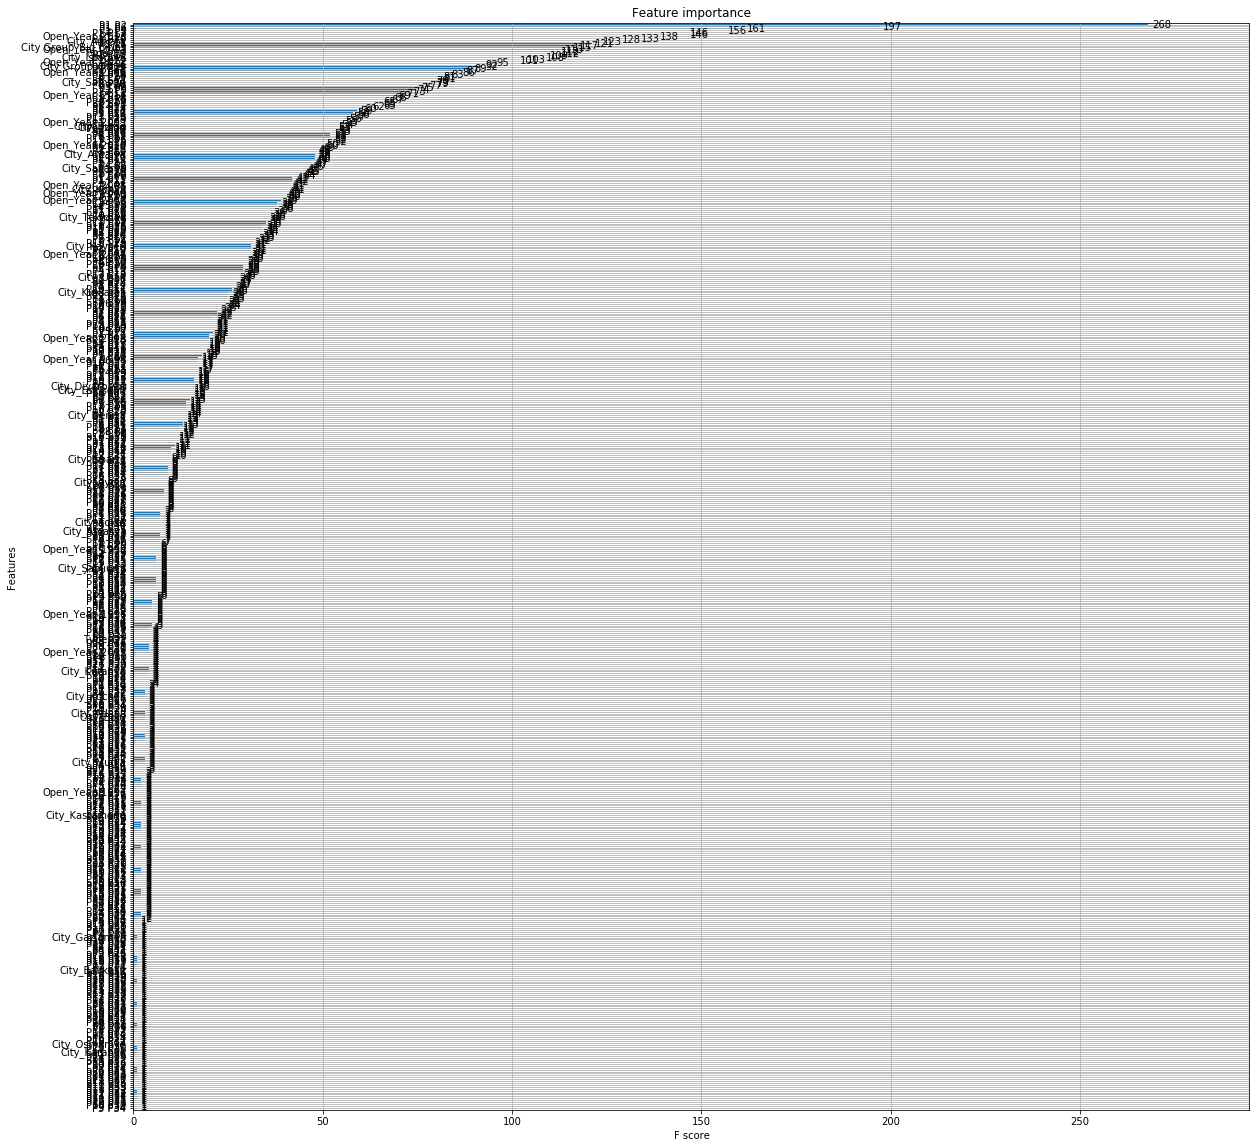

In [57]:
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_importance(xgbFinal, ax=ax)

# Prediction for Kaggle Submission

In [126]:
xgbFinal_submission = xgbFinal.predict(xgb.DMatrix(test_rf_x_interaction))
xgbFinal_submission = np.square(np.exp(xgbFinal_submission))

In [127]:
## Other submission style
## Creating a Submission File to submit to Kaggle competition ##
testData = pd.read_csv("test.csv")
submission = pd.DataFrame({
        "Id": testData["Id"],
        "Prediction": xgbFinal_submission
    })
submission.to_csv('XGboost_drop_features_interaction_testing_32th_trial.csv',header=True, index=False)

# Saving the final model

In [140]:
pickle.dump(xgbFinal, open("xgbFinal.pickle.dat", "wb"))

# Loading the final model

In [142]:
xgb_test = pickle.load(open("xgbFinal.pickle.dat", "rb"))

In [143]:
# Re-forecast the prediction to verify the model
xgb_test_p = xgb_test.predict(xgb.DMatrix(test_rf_x))
xgb_test_p = np.exp(xgb_test_p)

In [150]:
verify_model = (xgbFinal_submission == xgb_test_p)
verify_model.sum()

100000